In [1]:
import pandas as pd
import os
from scipy.interpolate import PchipInterpolator
import numpy as np
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import matplotlib.pyplot as plt

x = np.linspace(0,1,9)
xx= np.linspace(0,1,1000)
def f(x):
    return 2*cos(pi/2 - 2*pi*x) + 6*cos(pi -6*pi*x) + 4*cos(8*pi*x) + 2*cos(3*pi/2 - 10*pi*x)



In [2]:
import numpy as np
import matplotlib.pyplot as plt

def arm_detector(data, num_ventanas=25, b=0.6):
    n = len(data)
    x = np.arange(n)
    
    # Calcular el tamaño de cada ventana
    window_size = n // num_ventanas

    # Lista para almacenar los porcentajes de puntos dentro de las regiones
    porcentajes = []

    # Ajustar y graficar el ajuste lineal por cada ventana con las líneas paralelas
    for i in range(0, n, window_size):
        end = i + window_size
        if end > n:
            end = n
        
        x_window = x[i:end].reshape(-1, 1)
        y_window = data[i:end]
        
        # Crear y ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(x_window, y_window)
        
        # Obtener la pendiente y la intersección de la recta ajustada
        pendiente = modelo.coef_[0]
        interseccion = modelo.intercept_
        
        # Predecir valores ajustados
        y_pred = modelo.predict(x_window)
                
        # Calcular las rectas paralelas desplazadas por 'b'
        y_paralela_superior = pendiente * x_window + (interseccion + b)
        y_paralela_inferior = pendiente * x_window + (interseccion - b)
                
        # Calcular el porcentaje de datos dentro de la región delimitada por las líneas paralelas
        dentro_region = np.sum((y_window >= y_paralela_inferior.flatten()) & (y_window <= y_paralela_superior.flatten()))
        fuera_region = len(y_window) - dentro_region
        
        # Calcular el porcentaje de datos dentro de la región respecto a los datos fuera de la región
        porcentaje = (dentro_region * 100)/(dentro_region + fuera_region)
        porcentajes.append(porcentaje)

    def indice_mayor_90(arr):
        n = len(arr)
    
        # Revisar cada índice para encontrar el primero que cumpla la condición
        for i in range(n):
            if np.all(arr[i:] > 80) and len(arr[i:]) > 4:
                return i
        # Si no hay tal índice, regresar el último índice
        return n - 1
    
    indice = indice_mayor_90(np.array(porcentajes))*window_size
    return indice

def J_univariante(X,tau, corte):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))
    ff2 = np.angle(np.fft.rfft(y1))
    if corte:
        print(len(ff1),len(ff2))
        transition_point1 = arm_detector(ff1)
        transition_point2 = arm_detector(ff2)
        if transition_point1 != transition_point2:
            transition_point1 = transition_point2 = min(transition_point1, transition_point2)
        ff2 = ff2[:transition_point2]
        ff1 = ff1[:transition_point1]
        print(len(ff1),len(ff2))
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        if np.linalg.norm(v1) == 0:
            v1_norm = v1
        else:
             v1_norm=v1/np.linalg.norm(v1)
        if np.linalg.norm(v2) == 0:
            v2_norm = v2
        else:
            v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)

    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J, angulos

In [3]:
def J_bivariante(X,Y,fases):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    ff1 = np.angle(np.fft.rfft(X))[:fases]
    ff2 = np.angle(np.fft.rfft(Y))[:fases]
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2=cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos=[]
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J,angulos

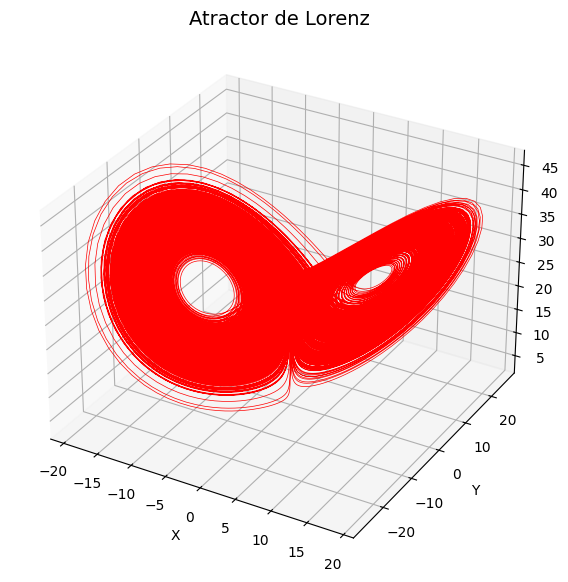

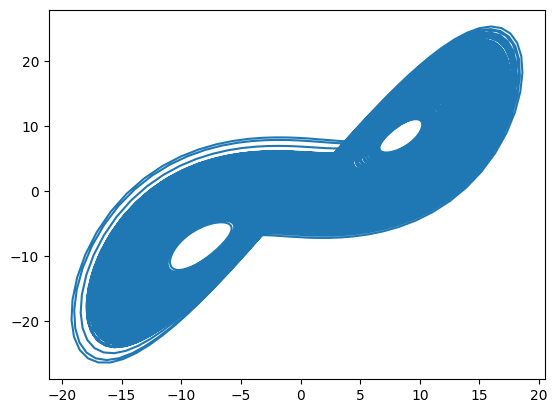

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del sistema
sigma = 10.0  # Parámetro sigma
beta = 8.0 / 3.0  # Parámetro beta
rho = 28.0  # Parámetro rho
dt = 0.01  # Paso de integración
transitorio = 50000  # Tiempo en pasos para eliminar el transitorio
total_puntos = 120001  # Número total de pasos

# Función del sistema de Lorenz
def lorenz_system(state, sigma, beta, rho):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

# Método de Runge-Kutta de cuarto orden
def runge_kutta_step(state, dt, sigma, beta, rho):
    k1 = lorenz_system(state, sigma, beta, rho)
    k2 = lorenz_system(state + 0.5 * dt * k1, sigma, beta, rho)
    k3 = lorenz_system(state + 0.5 * dt * k2, sigma, beta, rho)
    k4 = lorenz_system(state + dt * k3, sigma, beta, rho)
    return state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

# Condición inicial
initial_state = np.array([1.0, 1.0, 1.0])

# Inicialización de arrays para almacenar resultados
states = np.zeros((total_puntos, 3))
states[0] = initial_state

# Integración numérica
for i in range(1, total_puntos):
    states[i] = runge_kutta_step(states[i - 1], dt, sigma, beta, rho)

# Eliminar el transitorio
states = states[transitorio:]

# Extraer coordenadas x, y, z
x, y, z = states[:, 0], states[:, 1], states[:, 2]

# Graficar el atractor
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5, color='red')
ax.set_title("Atractor de Lorenz", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()
plt.plot(x,y)
plt.show()


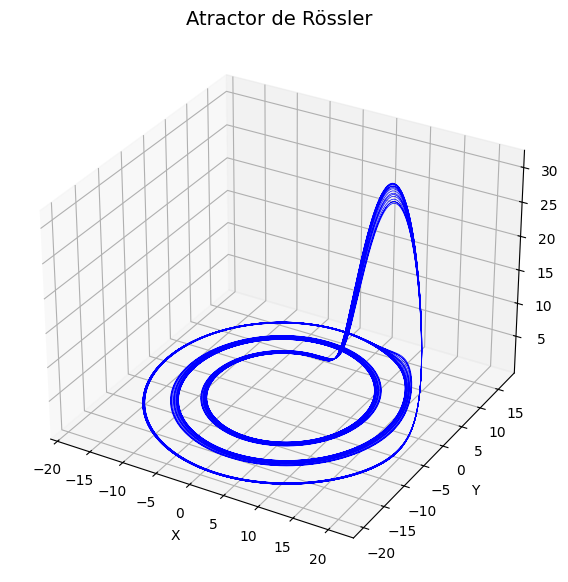

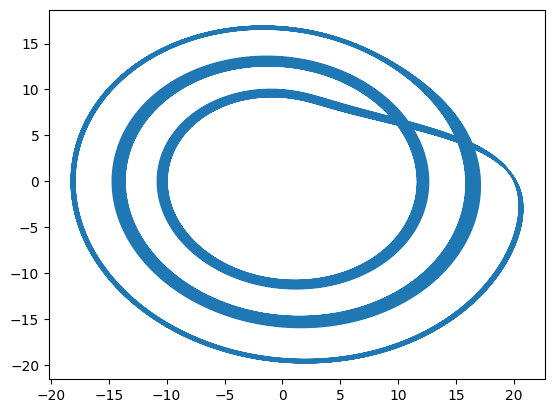

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del sistema
a = 0.1
b = 0.1
c = 13.0
dt = 0.01  # Paso de integración
transitorio = 50000  # Tiempo en pasos para eliminar el transitorio
total_puntos = 80001  # Número total de pasos

# Función del sistema de Rössler
def rossler_system(state, a, b, c):
    x, y, z = state
    dx = -y - z
    dy = x + a * y
    dz = b + z * (x - c)
    return np.array([dx, dy, dz])

# Método de Runge-Kutta de cuarto orden
def runge_kutta_step(state, dt, a, b, c):
    k1 = rossler_system(state, a, b, c)
    k2 = rossler_system(state + 0.5 * dt * k1, a, b, c)
    k3 = rossler_system(state + 0.5 * dt * k2, a, b, c)
    k4 = rossler_system(state + dt * k3, a, b, c)
    return state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

# Condición inicial
initial_state = np.array([1.0, 1.0, 1.0])

# Inicialización de arrays para almacenar resultados
states = np.zeros((total_puntos, 3))
states[0] = initial_state

# Integración numérica
for i in range(1, total_puntos):
    states[i] = runge_kutta_step(states[i - 1], dt, a, b, c)

# Eliminar el transitorio
states = states[transitorio:]

# Extraer coordenadas x, y, z
x, y, z = states[:, 0], states[:, 1], states[:, 2]

# Graficar el atractor
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5, color='blue')
ax.set_title("Atractor de Rössler", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()
plt.plot(x,y)


In [4]:
x = np.loadtxt('lorenz_x_28.0.txt')
y = np.loadtxt('lorenz_y_28.0.txt')
import numpy as np

def effective_cutoff_index(x, threshold=1e-6):
    X = np.fft.rfft(x)
    P = np.abs(X)**2
    max_power = np.max(P)
    cutoff_index = np.where(P >= max_power * threshold)[0][-1]
    return cutoff_index

effective_cutoff_index(x)

5010

In [5]:
def J_univariante1(X,tau,fases):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))[:fases]
    ff2 = np.angle(np.fft.rfft(y1))[:fases]
    
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        if np.linalg.norm(v1) == 0:
            v1_norm=v1
        else:
            v1_norm=v1/np.linalg.norm(v1)
        if np.linalg.norm(v2) == 0:
            v2_norm=v2
        else:
            v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

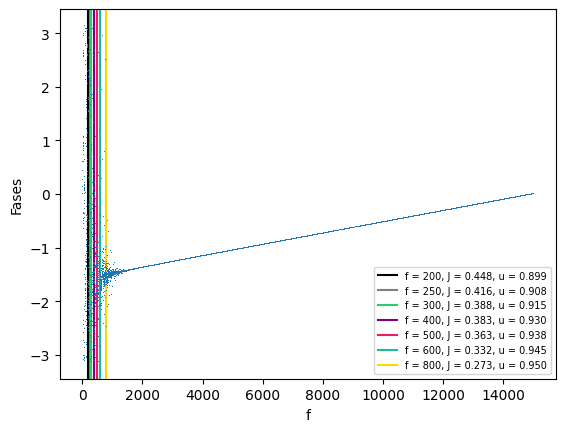

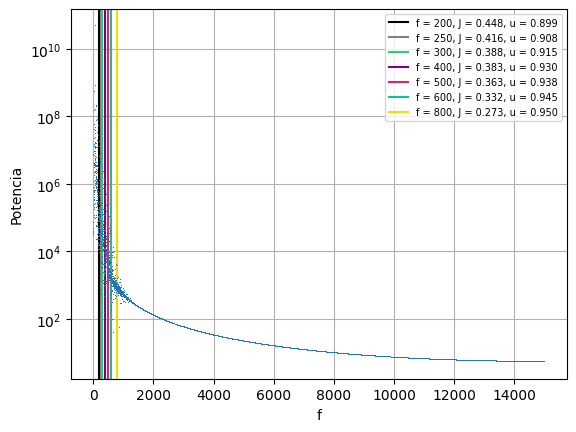

In [21]:
fases = np.angle(np.fft.rfft(x))
fasesy = np.angle(np.fft.rfft(y))
pot = (np.abs(np.fft.rfft(x)))**2
J_minus = np.load('J_minus_continuo.npy')
colores = ['black','gray','#2ECC71','purple','#E91E63','#1ABC9C', '#FFD700']
for i,corte in enumerate([200,250,300,400,500,600,800]):
    J,angulos = J_bivariante(x,y,corte)
    # plt.plot(angulos,'.')
    # plt.show()
    plt.axvline(corte, label = f'f = {corte}, J = {J:.3f}, u = {J_minus[1,np.where(J_minus[0,:] == corte*2)][0][0]:.3f}',color = colores[i])
plt.plot(fases,",")
plt.legend(loc='lower right',fontsize=7)
# plt.xlim(0,2000)
plt.xlabel('f')
plt.ylabel('Fases')
plt.show()

for i,corte in enumerate([200,250,300,400,500,600,800]):
    J = J_bivariante(x,y,corte)[0]
    plt.axvline(corte, label = f'f = {corte}, J = {J:.3f}, u = {J_minus[1,np.where(J_minus[0,:] == corte*2)][0][0]:.3f}',color = colores[i])
plt.plot(pot,",")
plt.legend(loc='upper right',fontsize=7)
# plt.xlim(0,2000)
# plt.ylim(0,1e4)
plt.yscale('log')
plt.grid()
plt.xlabel('f')
plt.ylabel('Potencia')
plt.show()